Neural Networks
===============

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$
$\newcommand{\eqdef}{\equiv}$

This tour details fully connected multi-layers neural netorks.

We recommend that after doing this Numerical Tours, you apply it to your
own data, for instance using a dataset from <https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/ LibSVM>.


_Disclaimer:_ these machine learning tours are intended to be
overly-simplistic implementations and applications of baseline machine learning methods.
For more advanced uses and implementations, we recommend
to use a state-of-the-art library, the most well known being
<http://scikit-learn.org/ Scikit-Learn>

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
#  convert to a column vector
def MakeCol(y): return y.reshape(-1,1)
#  convert to a row vector
def MakeRow(y): return y.reshape(1,-1)
# find non zero/true elements
def find(x): return np.nonzero(x)[0]

Dataset Generation
------------------
Build a synthetic data set for classification


Generate Data

In [3]:
n0 = 100 # number of points per class
p = 2   # dimensionality
k = 3   # number of classes
n = n0*k # Total number of points
x = np.zeros((p,n))
y = np.zeros((1,n))
for j in np.arange(0,k):
    I = np.arange(n0*(j-1),n0*j)
    r = np.linspace(0.0,1,n0) # radius
    t = np.linspace(j*4,(j+1)*4,n0) + np.random.randn(1,n0)*0.2 # angle
    x[0,I] = r*np.sin(t)
    x[1,I] = r*np.cos(t)
    y[0,I] = j

Display.

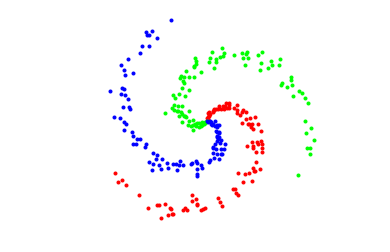

In [4]:
col = np.array( [ [1,0,0], [0,1,0], [0,0,1], [0,0,0], [0,1,1], [1,0,1], [1,1,0], [1,.5,.5], [.5,1,.5], [.5,.5,1]  ] ).transpose()
plt.clf
for j in np.arange(0,k):
    I = find(y.flatten()==j)
    plt.plot(x[0,I], x[1,I], '.', color=col[:,j])
plt.axis('equal')
plt.axis('off');

Class probability matrix.

In [5]:
U = np.tile( MakeCol(np.arange(1,k+1)), (1,n) )
Y = np.double( U == np.tile( y+1, (k,1) ) )

Building the Network
--------------------
We setup the network. It is parameterized by the dimensions of the layers.


The network is composed of $R$ layers, and operate by initialyzing $x_0=x$ and then iterating
$$ \forall r=0,\ldots,R, \quad x_{r+1} \eqdef \rho(A_r x_r + b_r).  $$
Here $\rho : \RR \mapsto \RR$ is a non-linear activation function which
operate coordinate by coordinate. The intermediate variables are $x_r \in \RR^{d_r}$
with $(d_0,d_{L+1})=(p,k)$. The matrices have size $A_r \in \RR^{d_{r+1} \times d_r}$
while the biases have size $b_r \in \RR^{d_{r+1}}$.


The final value is obtained by comparing the predicted value $x_{R+1}$
to the data $y$ using some loss function
$$ \ell \eqdef \Ll(x_{R+1},y). $$


Load the loss and its gradient.
Here we use a multi-class logistic loss
$$ \Ll(z,y) \eqdef \log \sum_{i=1}^k e^{z_i} - \dotp{z}{y}.  $$


Note that in practice the computation is done in parallel over an array
$x$ of size $(p,n)$ of $n$ points in $\RR^p$, where the class
probability to predict is an array $y$ of size $k,n$ where $k$ is
the number of classes.

Useful helpers.

In [6]:
def dotp(x,y): return x.flatten().dot( y.flatten().transpose() )
def max2(S): return np.tile( S.max(axis=1,keepdims=1), (1,S.shape[1]) )

Stabilized log-sum-exp

In [7]:
def LSE0(S): return np.log( np.exp(S).sum(axis=1,keepdims=1))
def LSE(S): return LSE0( S-max2(S) ) + S.max(axis=1,keepdims=1)

stabilized soft-max

In [8]:
def SM0(S): return np.exp(S) / np.tile( np.exp(S).sum(axis=1,keepdims=1), (1, S.shape[1]) )
def SM(S): return SM0(S-max2(S))

Energy, $y$ being a target probability distribution

In [9]:
def lossF(z,y): return LSE(z.transpose()).sum() - dotp(z,y)

gradient

In [10]:
def lossG(z,y): return SM(z.transpose()).transpose() -  y

Load the activation function. Here we use an atan sigmoid function.

In [11]:
def rhoF(u): return np.arctan(u)
def rhoG(u): return 1/(1+u**2)

Display the activation.

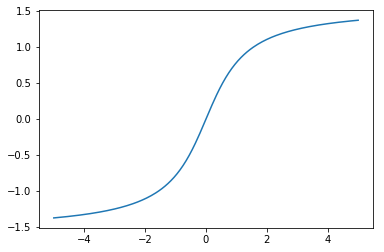

In [12]:
t = np.linspace(-5,5,201)
plt.clf
plt.plot(t, rhoF(t))
plt.axis('tight');

Dimensions $d_r$ of the layers.

In [13]:
D = np.array([p,15,k]) # here a single hidden layer

Initialize the layers randomly.

In [14]:
R = D.size-1 
A = []
b = [] 
for r in np.arange(0,R):
    A.append(np.random.randn(D[r+1],D[r]))
    b.append(np.random.randn(D[r+1],1))

Evaluate the network.
Bookkeep the intermediate results: this is crucial for the computation of
the gradient.

In [15]:
def ForwardNN(A,b,Z):
    X = []
    X.append(Z)
    for r in np.arange(0,R):
        X.append( rhoF( A[r].dot(X[r]) + np.tile(b[r],[1,Z.shape[1]]) ) )
    return X
X = ForwardNN(A,b,x)
L = lossF(X[R],Y)

Network Optimization
--------------------
The network parameters are optimized by minimizing the non-convex
empirical loss minimization through gradient descent.


Initialize the gradient as
$$ \nabla_{x_{R+1}} \ell = \nabla \Ll(x_{R+1},y) $$

In [16]:
gx = lossG(X[R],Y)

The successive gradient with respect to the intermediate variables $x_r$
are solutions of a backward recursion, which
corresponds to the celebrated backpropagation algorithm.
$$ \forall r=R,\ldots,1, \quad
      \nabla_{x_{r}} \ell = A_r^\top M_r $$
where we denoted
$$ M_r \eqdef \rho'(A_r x_r + b_r ) \odot \nabla_{x_{r+1}} \ell, $$
where $\odot$ is entry-wise multiplications.


From these gradients with respect to the intermediate layers variables, the
gradient with respect to the network  paramters are retrieved as
$$ \nabla_{A_r} \ell = M_r x_r^\top, \qandq
    \nabla_{b_r} \ell = M_r 1_n.  $$


Perform the back-propagation.

In [17]:
def BackwardNN(A,b,X):
    gA = [] # gradient with respect to A
    gb = [] # gradient with respect to b
    for r in np.arange(0,R):
        gA.append([]) 
        gb.append([])
    gx = lossG(X[R],Y) # initialize the gradient
    for r in np.arange(R-1,-1,-1):
        M = rhoG( A[r].dot(X[r]) + np.tile(b[r],[1,n]) ) * gx
        # nabla_X[r] 
        gx = A[r].transpose().dot(M)
        # nabla_A[r]
        gA[r] =  M.dot(X[r].transpose())
        # nabla_b[r]
        gb[r] =  MakeCol(M.sum(axis=1))
    return [gA,gb]

__Exercise 1__

Implement the gradient descent.

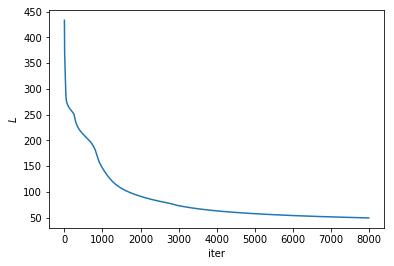

In [18]:
run -i nt_solutions/ml_5_nn/exo1

In [19]:
## Insert your code here.

Grid for evaluation.

In [20]:
q = 100;
t = np.linspace(-1,1,q)
[Yg,Xg] = np.meshgrid(t,t)
Z = np.vstack([Xg.flatten(), Yg.flatten()])

Classification maps

In [21]:
V = ForwardNN(A,b,Z)
U = np.reshape(SM(V[R].transpose()), [q,q,k] )

Turn it into color.

In [22]:
R = np.zeros((q,q,3))
for i in np.arange(0,k):
    for a in np.arange(0,3):
        R[:,:,a] = R[:,:,a] + U[:,:,i] * col[a,i]

Final display of points and class probability.

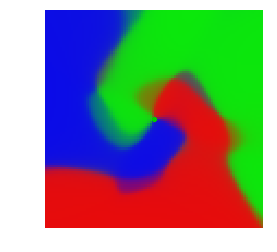

In [23]:
M=1
plt.clf
plt.imshow(R.transpose((1, 0, 2)), origin="lower", extent=[-M,M,-M,M])
for i in np.arange(0,k):
    I = find(y==i+1)
    plt.plot(x[0,I], x[1,I], '.', color=col[:,i]*.8)
plt.axis('off');

__Exercise 2__

Check the influence of the number of layers

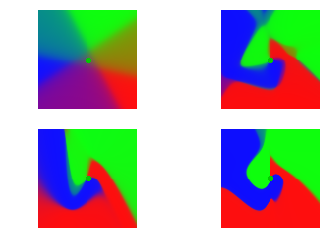

In [24]:
run -i nt_solutions/ml_5_nn/exo2

In [25]:
## Insert your code here.